In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
import requests

url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

r = requests.get(url, allow_redirects=True)

with open('Data/course_lead_scoring.csv', 'wb') as f:
    f.write(r.content)
    
r.status_code

200

In [9]:
df= pd.read_csv('Data/course_lead_scoring.csv')
df.shape

(1462, 9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [24]:
df['converted'].value_counts()

converted
1    905
0    557
Name: count, dtype: int64

In [12]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [19]:
# Categorical features
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('NA')
# Numerical features
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(0)

### Question 1
What is the most frequent observation (mode) for the column industry?

In [22]:
df['industry'].value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

### Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

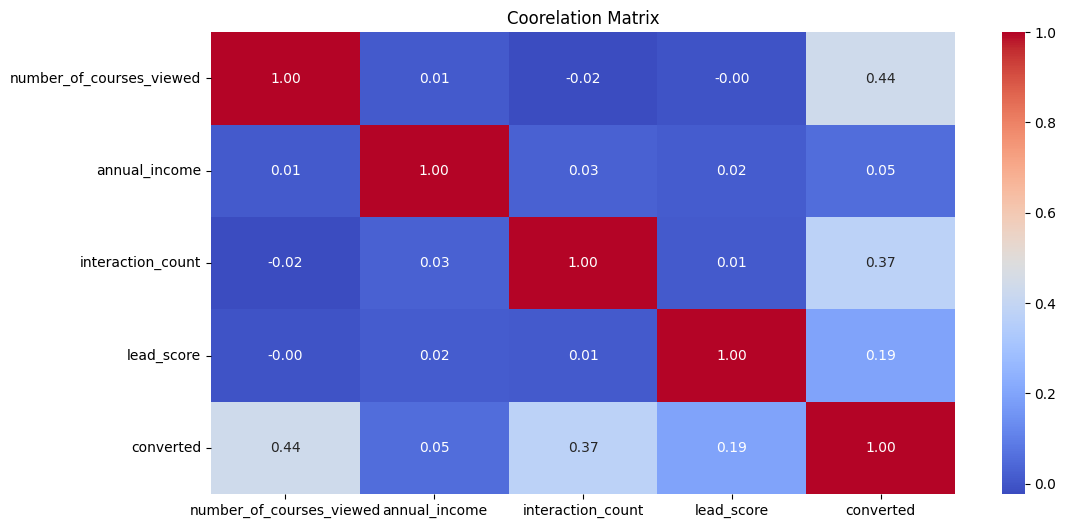

In [20]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Coorelation Matrix")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split

def prepare_data(df: pd.DataFrame, seed: int = 42):

    df_s = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    train_size = 0.6
    val_size = 0.2
    test_size = 0.2

    X = df_s.drop(columns=['converted'])
    y = df_s['converted']

    X_train, X_temp, y_train, y_temp = train_test_split(
                                    X, y, test_size = (1 - train_size), 
                                    random_state=seed, 
                                    )

    X_val, X_test, y_val, y_test = train_test_split(
                                X_temp, y_temp, test_size = (test_size / (val_size + test_size)), 
                                random_state=seed, 
                                )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Question 3
Calculate the mutual information score between converted and other categorical variables in the dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).
Which of these variables has the biggest mutual information score?

In [ ]:
from sklearn.metrics import mutual_info_score

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df)

def mi_converter_score(series):
    return mutual_info_score(series, y_train)

X_train[cat_cols].apply(mi_converter_score)

lead_source          0.022869
industry             0.012674
employment_status    0.011321
location             0.003715
dtype: float64

### Question 4\
Now let's train a logistic regression.
Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.\
Fit the model on the training dataset.\
To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:\
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)\
Calculate the accuracy on the validation dataset and round it to 2 decimal digits.\
What accuracy did you get?

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoder_features = encoder.fit_transform(df[cat_cols])
df_final = pd.DataFrame(encoder_features, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
df_final = pd.concat([df[num_cols].reset_index(drop=True), df_final.reset_index(drop=True)], axis=1)

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_final)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [47]:
from sklearn.metrics import accuracy_score

y_val_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.702


### Question 5
Let's find the least useful feature using the feature elimination technique.\
Train a model using the same features and parameters as in Q4 (without rounding).\
Now exclude each feature from this set and train a model without it. Record the accuracy for each model.\
For each feature, calculate the difference between the original accuracy and the accuracy without the feature.\
Which of following feature has the smallest difference?

In [67]:
diff_features = {}

feature_columns = df.columns.drop('converted')
feature_columns

for col in feature_columns:

    data = df.drop(columns=[col])
    cat_cols = data.select_dtypes(include=['object']).columns
    num_cols = data.select_dtypes(include=['number']).columns

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    
    encoder_features = encoder.fit_transform(data[cat_cols])
    df_final = pd.DataFrame(encoder_features, columns=encoder.get_feature_names_out(cat_cols), index=data.index)
    df_final = pd.concat([data[num_cols].reset_index(drop=True), df_final.reset_index(drop=True)], axis=1)

    X_train_temp, X_val_temp, X_test_temp, y_train, y_val, y_test = prepare_data(df_final)

    model_subset = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model_subset.fit(X_train_temp, y_train)
    
    y_val_pred_subset = model_subset.predict(X_val_temp)
    accuracy_subset = accuracy_score(y_val, y_val_pred_subset)
    
    diff_features[col] = accuracy - accuracy_subset

In [68]:
columns = ['industry','employment_status','lead_score']
for col in columns:
    print(col, diff_features[col])

industry 0.003424657534246589
employment_status 0.010273972602739767
lead_score 0.003424657534246589


### Question 6
Now let's train a regularized logistic regression.\
Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].\
Train models using all the features as in Q4.\
Calculate the accuracy on the validation dataset and round it to 3 decimal digits.\
Which of these C leads to the best accuracy on the validation set?

In [69]:
C_values = [0.01, 0.1, 1, 10, 100]

val_scores = {}

for c in C_values:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    val_scores[c] = round(acc, 3)

val_scores


{0.01: 0.692, 0.1: 0.699, 1: 0.702, 10: 0.702, 100: 0.702}